In [1]:
import pandas as pd

data = pd.read_csv('/content/drive/MyDrive/enron_processed.csv.gz', compression= 'gzip')

In [2]:
data = data.dropna()

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_len = 300
training_samples = 10000
max_words = 500


tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(data['email_body'].values)
sequences = tokenizer.texts_to_sequences(data['email_body'].values)

In [4]:
word_index = tokenizer.word_index
print('%s : Unique tokens' % len(word_index))

data = pad_sequences(sequences, maxlen = max_len)

602804 : Unique tokens


In [5]:
from sklearn.cluster import MiniBatchKMeans

kmc = MiniBatchKMeans(n_clusters = 10, verbose = 1, batch_size = 100, random_state = 256)
kmc.fit(data)

Init 1/3 with method: k-means++
Inertia for init 1/3: 532244482.062256
Init 2/3 with method: k-means++
Inertia for init 2/3: 527230579.448782
Init 3/3 with method: k-means++
Inertia for init 3/3: 507850023.917067
Minibatch iteration 1/517100: mean batch inertia: 1797733.855640, ewa inertia: 1797733.855640 
Minibatch iteration 2/517100: mean batch inertia: 1571704.242502, ewa inertia: 1797646.430584 
Minibatch iteration 3/517100: mean batch inertia: 1777197.217182, ewa inertia: 1797638.521118 
Minibatch iteration 4/517100: mean batch inertia: 1633367.585238, ewa inertia: 1797574.983444 
Minibatch iteration 5/517100: mean batch inertia: 1820592.658102, ewa inertia: 1797583.886355 
Minibatch iteration 6/517100: mean batch inertia: 1769743.758542, ewa inertia: 1797573.118188 
Minibatch iteration 7/517100: mean batch inertia: 1555917.995780, ewa inertia: 1797479.649406 
Minibatch iteration 8/517100: mean batch inertia: 1672924.607903, ewa inertia: 1797431.473279 
Minibatch iteration 9/51710

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=256,
                reassignment_ratio=0.01, tol=0.0, verbose=1)

In [6]:
data.shape

(517081, 300)

In [7]:
labels = kmc.predict(data)

Computing label assignment and total inertia


In [8]:
from keras.utils import to_categorical

training_data = data[:400000]
training_labels = to_categorical(labels[:400000])

test_data = data[400000:]
test_labels = to_categorical(labels[400000:])

In [9]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-03-03 00:36:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-03 00:36:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-03 00:36:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [10]:
path_to_zip_file = '/content/glove.6B.zip'
directory_to_extract_to = '/content/'

import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [11]:
import numpy as np

embeddings_index = {}
f = open('/content/glove.6B.100d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  embeddings_index[word] = coefs
f.close()

print(len(embeddings_index))

400000


In [12]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=max_len))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          50000     
_________________________________________________________________
flatten (Flatten)            (None, 30000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                960032    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 1,010,362
Trainable params: 1,010,362
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [15]:
model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['acc'])
history = model.fit(training_data, 
                    training_labels, 
                    epochs = 10, 
                    batch_size=32, 
                    validation_split= .2)

model.save_weights('/content/drive/MyDrive/pretrained_glove.h5')

Epoch 1/10
10000/10000 [==============================] - 154s 15ms/step - loss: 0.4250 - acc: 0.8551 - val_loss: 0.3639 - val_acc: 0.8827
Epoch 2/10
10000/10000 [==============================] - 146s 15ms/step - loss: 0.2488 - acc: 0.9126 - val_loss: 0.3990 - val_acc: 0.8856
Epoch 3/10
10000/10000 [==============================] - 151s 15ms/step - loss: 0.1974 - acc: 0.9330 - val_loss: 0.4833 - val_acc: 0.8890
Epoch 4/10
10000/10000 [==============================] - 147s 15ms/step - loss: 0.1651 - acc: 0.9444 - val_loss: 0.5622 - val_acc: 0.8890
Epoch 5/10
10000/10000 [==============================] - 153s 15ms/step - loss: 0.1441 - acc: 0.9542 - val_loss: 0.6364 - val_acc: 0.8849
Epoch 6/10
10000/10000 [==============================] - 149s 15ms/step - loss: 0.1298 - acc: 0.9603 - val_loss: 0.7590 - val_acc: 0.8861
Epoch 7/10
10000/10000 [==============================] - 157s 16ms/step - loss: 0.1160 - acc: 0.9649 - val_loss: 0.8693 - val_acc: 0.8845
Epoch 8/10
10000/10000 [===

In [13]:
import matplotlib.pyplot as plt
def plot_acc(model, name):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label = 'Training acc')
  plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
  plt.title('%s training and validation accuracy' % name)
  plt.legend()

In [14]:
def plot_val(model,name):
  loss= model.history['loss']
  val_loss = model.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.plot(epochs, loss, 'ro', label = 'Training loss')
  plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
  plt.title('%s training and validation loss' % name)
  plt.legend()
  plt.show()

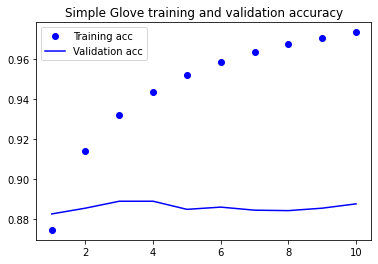

In [18]:
plot_acc(history, 'Simple Glove')

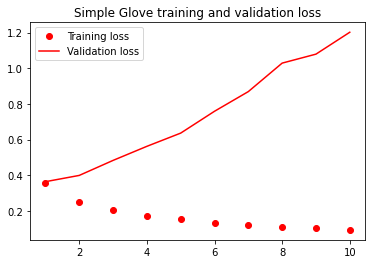

In [19]:
plot_val(history, 'Simple Glove')

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(SimpleRNN(32, return_sequences = True))
model.add(SimpleRNN(32))
model.add(Dense(10, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          50000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 300, 32)           4256      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 10)                330       
Total params: 56,666
Trainable params: 56,666
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

history = model.fit(training_data, 
                    training_labels, 
                    epochs = 10, 
                    batch_size=32, 
                    validation_split= .2)

model.save_weights('/content/drive/MyDrive/glove_simpleRNN.h5')

Epoch 1/10
10000/10000 [==============================] - 1164s 116ms/step - loss: 0.7143 - acc: 0.7290 - val_loss: 1.3365 - val_acc: 0.6064
Epoch 2/10
10000/10000 [==============================] - 1175s 117ms/step - loss: 0.2839 - acc: 0.8970 - val_loss: 0.4399 - val_acc: 0.8497
Epoch 3/10
10000/10000 [==============================] - 1169s 117ms/step - loss: 0.3485 - acc: 0.8724 - val_loss: 0.2195 - val_acc: 0.9237
Epoch 4/10
10000/10000 [==============================] - 1170s 117ms/step - loss: 0.7229 - acc: 0.7298 - val_loss: 0.9261 - val_acc: 0.5816
Epoch 5/10
10000/10000 [==============================] - 1171s 117ms/step - loss: 0.8121 - acc: 0.6806 - val_loss: 1.2435 - val_acc: 0.4790
Epoch 6/10
10000/10000 [==============================] - 1173s 117ms/step - loss: 1.2603 - acc: 0.5068 - val_loss: 1.4384 - val_acc: 0.4400
Epoch 7/10
10000/10000 [==============================] - 1174s 117ms/step - loss: 1.1706 - acc: 0.5480 - val_loss: 0.8615 - val_acc: 0.6624
Epoch 8/10
10

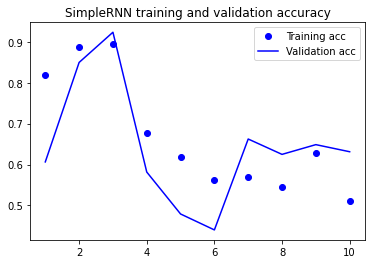

In [17]:
plot_acc(history, 'SimpleRNN')

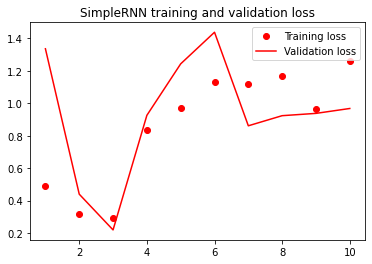

In [18]:
plot_val(history, 'SimpleRNN')

In [19]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(32, return_sequences = True))
model.add(LSTM(32))
model.add(Dense(10, activation = 'softmax'))

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          50000     
_________________________________________________________________
lstm (LSTM)                  (None, 300, 32)           17024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 75,674
Trainable params: 25,674
Non-trainable params: 50,000
_________________________________________________________________


In [ ]:
model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

history = model.fit(training_data, 
                    training_labels, 
                    epochs = 10, 
                    batch_size=32, 
                    validation_split= .2)

model.save_weights('/content/drive/MyDrive/glove_LSTM.h5')

Epoch 1/10
10000/10000 [==============================] - 1838s 183ms/step - loss: 0.5842 - acc: 0.7920 - val_loss: 0.3128 - val_acc: 0.8845
Epoch 2/10
10000/10000 [==============================] - 1887s 189ms/step - loss: 0.2912 - acc: 0.8926 - val_loss: 0.2432 - val_acc: 0.9092
Epoch 3/10
 9491/10000 [===========================>..] - ETA: 1:36 - loss: 0.2702 - acc: 0.9034

In [ ]:
plot_acc(history, 'LSTM')

In [ ]:
plot_val(history, 'LSTM')

In [ ]:
history.evaluate(test)

In [ ]:
import pandas as pd
from keras.utils import to_categorical

label_dist_data = pd.DataFrame(to_categorical(labels))

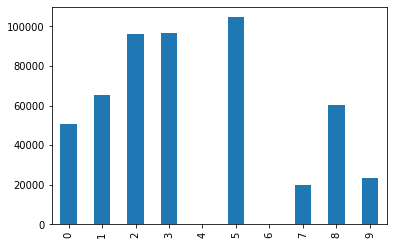

In [ ]:
label_dist_data.sum().plot.bar()

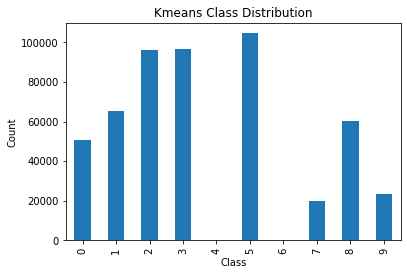

In [ ]:
  import matplotlib.pyplot as plt
  label_dist_data.sum().plot.bar()
  plt.title('Kmeans Class Distribution')
  plt.xlabel('Class')
  plt.ylabel('Count')
  plt.show()